### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


from torch import utils
from torch import nn
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms

### Constants and definitions

In [2]:
%matplotlib inline

BATCH_SIZE = 64
DATA_FOLDER = '../data/CelebA/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ENCODED_DIMS = 200
IMAGE_SIZE = 128
R_LOSS_SCALE = 1000

### Data loading

Load entire dataset:

In [3]:
dataset = datasets.ImageFolder(root=DATA_FOLDER,
                               transform = transforms.Compose([
                                   transforms.Resize(IMAGE_SIZE),
                                   transforms.CenterCrop(IMAGE_SIZE),
                                   transforms.ToTensor(),
                                   transforms.Normalize((.5, .5, .5), (.5, .5, .5))
                               ]))

Split into training and test sets:

In [4]:
# get entire dataset size
dataset_size = len(dataset)

# get train and test sets sizes
train_size = int(dataset_size * 0.99)
test_size = dataset_size - train_size

# split train and test sets
train_set, test_set = utils.data.random_split(dataset, (train_size, test_size))

# report
print(f'CelebA size: {dataset_size} images\n'
      f'Training set size: {train_size} images\n'
      f'Test set size: {test_size} images')

CelebA size: 202599 images
Training set size: 200573 images
Test set size: 2026 images


Create data loaders:

In [5]:
train_loader = utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = utils.data.DataLoader(test_set, batch_size = BATCH_SIZE * 2, shuffle = False)

Visualize:

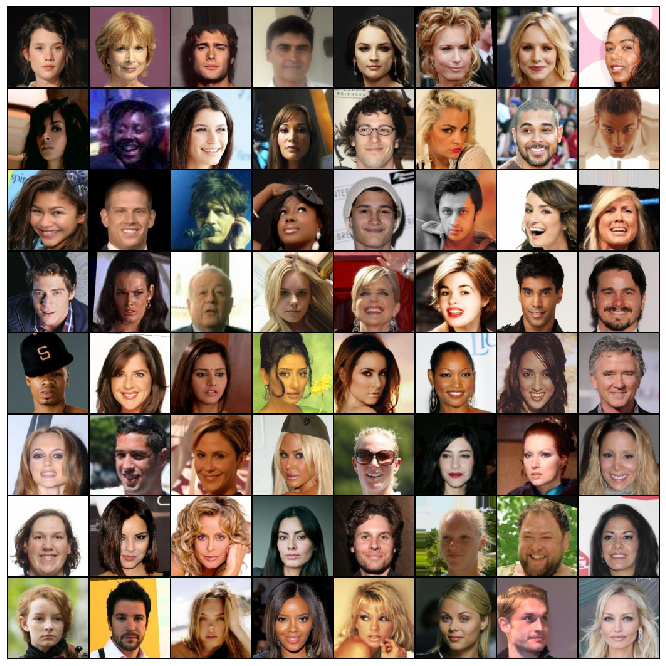

In [6]:
# get sample batch
sample = next(iter(train_loader))

# create image grid
grid = torchvision.utils.make_grid(sample[0].to('cpu')[:64], padding = 2, normalize = True)

# plot
plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(np.transpose(grid, (1, 2, 0)))

### Sampler

Sampler layer definition:

In [7]:
class Sampler(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, mu, log_var):
        epsilon = torch.randn_like(mu)
        return mu + torch.exp(log_var / 2) * epsilon 

### Encoder

Encoder model definition:

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(),

            nn.Flatten()
        )
        
        self.mu = nn.Linear(4096, ENCODED_DIMS)
        self.log_var = nn.Linear(4096, ENCODED_DIMS)
        self.sample = Sampler()
        
    def forward(self, x):
        x = self.encode(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        sampled = self.sample(mu, log_var)
        
        return mu, log_var, sampled

Create encoder:

In [9]:
encoder = Encoder()
encoder = encoder.to(DEVICE)

Visualize model:

In [10]:
summary(encoder, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
         Dropout2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         LeakyReLU-7           [-1, 64, 32, 32]               0
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
        Dropout2d-12           [-1, 64, 16, 16]               0
           Conv2d-13             [-1, 64, 8, 8]          36,928
      BatchNorm2d-14             [-1, 6

### Decoder

Decoder model definition:

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(ENCODED_DIMS, 4096)
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            
            nn.ConvTranspose2d(64, 64, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            
            nn.ConvTranspose2d(64, 32, 3, 2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            
            nn.ConvTranspose2d(32, 3, 3, 2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.lin(x)
        x = x.view(-1, 64, 8, 8)
        x = self.decode(x)
        return x

Create decoder:

In [12]:
decoder = Decoder()
decoder = decoder.to(DEVICE)

Visualize model:

In [13]:
summary(decoder, (200, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         823,296
   ConvTranspose2d-2           [-1, 64, 16, 16]          36,928
       BatchNorm2d-3           [-1, 64, 16, 16]             128
         LeakyReLU-4           [-1, 64, 16, 16]               0
         Dropout2d-5           [-1, 64, 16, 16]               0
   ConvTranspose2d-6           [-1, 64, 32, 32]          36,928
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         LeakyReLU-8           [-1, 64, 32, 32]               0
         Dropout2d-9           [-1, 64, 32, 32]               0
  ConvTranspose2d-10           [-1, 32, 64, 64]          18,464
      BatchNorm2d-11           [-1, 32, 64, 64]              64
        LeakyReLU-12           [-1, 32, 64, 64]               0
        Dropout2d-13           [-1, 32, 64, 64]               0
  ConvTranspose2d-14          [-1, 3, 1

### Convolutional Variational Autoencoder

Define joint model:

In [14]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        mu, log_var, x = self.encoder(x)
        x = self.decoder(x)
        return mu, log_var, x      

Create variational autoencoder:

In [15]:
vae = VAE()
vae = vae.to(DEVICE)

Visualize model:

In [16]:
summary(vae, (3, 128, 128), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 64, 64]             896
       BatchNorm2d-2           [64, 32, 64, 64]              64
         LeakyReLU-3           [64, 32, 64, 64]               0
         Dropout2d-4           [64, 32, 64, 64]               0
            Conv2d-5           [64, 64, 32, 32]          18,496
       BatchNorm2d-6           [64, 64, 32, 32]             128
         LeakyReLU-7           [64, 64, 32, 32]               0
         Dropout2d-8           [64, 64, 32, 32]               0
            Conv2d-9           [64, 64, 16, 16]          36,928
      BatchNorm2d-10           [64, 64, 16, 16]             128
        LeakyReLU-11           [64, 64, 16, 16]               0
        Dropout2d-12           [64, 64, 16, 16]               0
           Conv2d-13             [64, 64, 8, 8]          36,928
      BatchNorm2d-14             [64, 6

### Loss function

Define Kullback–Leibler (KL) divergence:

In [17]:
def KLDivergenceLoss(mu, log_var):
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

Combine MSE and KL-Divergence into single loss:

In [18]:
def loss(y_hat, y, mu, log_var):
    return R_LOSS_SCALEL * F.mse_loss(y_hat, y) + KLDivergenceLoss(mu, log_var)